# Predicting Blight Violations

_This project was completed as a part of the Applied Data Science with Python Specialization from Coursera._

In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from Blight Violation Notices (BVN), or Blight Tickets, that have been issued to property owners who have violated City of Detroit ordinances that govern how property owners must maintain the exterior of their property. Blight Tickets are issued by city inspectors, police officers, neighborhood city hall managers and other city officials who investigate complaints of blight and are managed by the Department of Administrative Hearings.

The target variable is compliance, which is __True__ if the ticket was paid early, on time, or within one month of the hearing data, __False__ if the ticket was paid after the hearing date or not at all, and __Null__ if the violator was found not responsible. Compliance is not avaliable in the dataset so it must be calculated.

The dataset for this project originates from the City of Detroit's Open Data Portal initiative and is updated daily. For this project the dataset spans tickets issued from March 2004 to March 2018. The dataset is avaliable at: https://data.detroitmi.gov/Property-Parcels/Blight-Violations/ti6p-wcg4

## Pre-Processing

Imports the raw data, calculates compliance for each ticket, removes features that cause data leakage, and seperates the data into two dataset based on when the violation occured. Violations issused before 2017 will be used to train and test the model, and tickets issued on and after 2017 will be used to validate the model.

In [1]:
# Common imports
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, hstack

# To make the notebook's output stable across runs
random_seed = 12062017
np.random.seed(random_seed)

matplotlib.style.use('ggplot') 
%matplotlib inline

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [3]:
def load_blight_raw(blight_path):
    '''
    Loads the raw blight_violations.csv
    Returns a pandas dataframe.
    '''
    csv_path = os.path.join(blight_path, "Blight_Violations.csv")
    blight_raw = pd.read_csv(csv_path, encoding='ISO-8859-1')
    print("RAW Blight Violations dataset has {} observations with {} features each.".format(*blight_raw.shape))
    return blight_raw

def pre_processing(blight_df):
    ''' 
    Takes blight panda dataframe and makes column names more reabable, sets ticket_id as index, creates compliance (the 
    prediction variable), and creates compliance_details (explains why a tickets was labeled as complantent or non-complantent).
    Returns a panda dataframe.
    '''
    # Makes column names more reabable
    # Gets columns from dataframe
    columns_names = pd.Series(blight_df.columns)
    # Removes parentheses, removes right spaces
    columns_names = columns_names.str.split('(').str[0].str.strip()
    # Coverts column names to lowercase and replaces spaces with underscores
    columns_names = columns_names.str.lower().str.replace(' ', '_')
    blight_df.columns = columns_names
    # Sets ticket_id as index
    blight_df.set_index('ticket_id', inplace=True)
    # Defines prediction variable compliance and helper variable compliance_detail
    # The values of these variables are NOT correct
    blight_df['compliance'] = 0
    blight_df['compliance_detail'] = np.NaN    
    return blight_df

def clean_up(blight_df):
    # Removes instances where 'ticket_issued_date' is not in (2000, 2017) 
    blight_df = blight_df[blight_df['violation_date'].str.contains('[0-9]{2}/[0-9]{2}/[20]{2}[0-9]{2}') == True]
    # Converts 'ticket_issued_date' to datetime
    blight_df.loc[:, 'violation_date'] = pd.to_datetime(blight_df['violation_date'])
    # Converts 'payment_date' to datetime
    blight_df.loc[:, 'payment_date'] = pd.to_datetime(blight_df['payment_date'].str.extract('([0-9]{2}/[0-9]{2}/20{1}[0-9]{2})')) 
    # Converts bad values in 'ticket_issued_time' to NaNs (Dataset error removed by publisher)
    #blight_df.loc[blight_df['violation_date'] == '00000000000000.000', 'violation_date'] = np.nan
    # Converts 'ticket_issued_time' to datetime.time
    blight_df.loc[:, 'ticket_issued_time'] = pd.DatetimeIndex(blight_df['ticket_issued_time']).time
    # Converts 'hearing_time' to datetime.time
    blight_df.loc[:, 'hearing_time'] = pd.DatetimeIndex(blight_df['hearing_time']).time
    # Remove "$" from 'judgement_amount'
    blight_df.loc[:, 'judgment_amount'] = blight_df['judgment_amount'].str.strip('$')    
    # Converts 'judgment_amount' to float    
    blight_df.loc[:, 'judgment_amount'] = blight_df['judgment_amount'].astype(float)
    # Removes "$" from 'payment_amount' and converts it to float
    blight_df.loc[:, 'payment_amount'] = blight_df['payment_amount'].str.strip('$').astype(float)
    # Removes "$" from 'fine_amount' and converts it to float
    blight_df.loc[:, 'fine_amount'] = blight_df['fine_amount'].str.strip('$').astype(float)
    # Removes "$" from 'admin_fee' and converts it to float
    blight_df.loc[:, 'admin_fee'] = blight_df['admin_fee'].str.strip('$').astype(float)
    # Removes "$" from 'state_fee' and converts it to float
    blight_df.loc[:, 'state_fee'] = blight_df['state_fee'].str.strip('$').astype(float)
    # Removes "$" from 'late_fee' and converts it to float
    blight_df.loc[:, 'late_fee']   = blight_df['late_fee'].str.strip('$').astype(float)
    # Removes "$" from 'discount_amount' and converts it to float
    blight_df.loc[:, 'discount_amount'] = blight_df['discount_amount'].str.strip('$').astype(float)    
    return blight_df

def null_compliance(blight_df):
    '''
    Compliance = np.NaN
    Tickets that cannot be classified as compliant or non-compliant because they were ruled as not responsible in disposition
    or they are awaiting judgement.
    Returns a pandas dataframe
    '''
    # Dispositions that are ruled as not responsible or are still pending
    null_dispositions = ['Not responsible by Dismissal', 'Not responsible by City Dismissal', 'PENDING JUDGMENT', 
                 'Not responsible by Determination','SET-ASIDE (PENDING JUDGMENT)', 'PENDING', 'Responsible by Dismissal']
    # Loops over dispositions and sets 'compliance' values to np.NaN
    # Loops over dispositions and sets 'compliance_detail' values to 'Not Responsible/Pending Judgement'
    for dispositions in null_dispositions:
        blight_df.loc[blight_df['disposition'] == dispositions, 'compliance'] = np.NaN
        blight_df.loc[blight_df['disposition'] == dispositions, 'compliance_detail'] = 'Not Responsible/Pending Judgement'
    return blight_df

def compliant(blight_df):
    '''
    Compliance = 1
    Tickets that are classified as compliant because they had no fine, fine was waved, made a payment with hearing pending,
    early payment (hearing not pending), payment on time, or payment within one month after hearing date.
    Returns a pandas dataframe
    '''
    ## Compliant by no fine
    # Fine Waived by Determintation
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination', 'compliance'] = 1
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination', 'compliance_detail'] = 'Compliant by no fine'
    # Fine Waived by Admission
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'compliance'] = 1
    blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'compliance_detail'] = 'Compliant by no fine'
    ## Compliant by Payment
    # Payment with PENDING hearing
    blight_df.loc[(
        (blight_df['hearing_date'] == 'PENDING') &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        (blight_df['hearing_date'] == 'PENDING') &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by payment with PENDING hearing'
    # Transforms values in 'hearing_date' and 'payment_date' to panda date types
    dummy_hearing_date = blight_df['hearing_date'].copy()
    blight_df.loc[blight_df['hearing_date'] == 'PENDING', 'hearing_date'] = np.nan
    blight_df.loc[:, 'hearing_date'] = pd.to_datetime(blight_df['hearing_date'].str.extract('([0-9]{2}/[0-9]{2}/20{1}[0-9]{2})'))
    # Early Payment, payment before hearing date
    blight_df.loc[(
        (blight_df['payment_date'] < blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        (blight_df['payment_date'] < blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by early payment'
    # Payment on time, payment on hearing date
    blight_df.loc[(
        (blight_df['payment_date'] == blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        (blight_df['payment_date'] == blight_df['hearing_date']) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by payment on time'
    # Payment within one month after hearing date
    blight_df.loc[(
        ((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M') <= 1.0) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance'] = 1
    blight_df.loc[(
        ((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M') <= 1.0) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Compliant by payment within 1 Month'
    # Sets 'hearing_date' to orginal state
    blight_df.loc[:, 'hearing_date'] = dummy_hearing_date
    return blight_df

def non_compliant(blight_df):
    '''
    Compliance = 0
    Tickets that are classified as non-compliant because they made no payment or a payment after one month (late payment).
    Returns a pandas dataframe
    '''
    # Transforms values in 'hearing_date' to panda date types
    dummy_hearing_date = blight_df['hearing_date'].copy()
    blight_df.loc[blight_df['hearing_date'] == 'PENDING', 'hearing_date'] = np.nan
    blight_df.loc[:, 'hearing_date'] = pd.to_datetime(blight_df['hearing_date'].str.extract('([0-9]{2}/[0-9]{2}/20{1}[0-9]{2})'))
    # Non-compliant by late payment
    blight_df.loc[(
        ((blight_df['payment_date'] - blight_df['hearing_date'])/np.timedelta64(1, 'M') > 1.0) &
        (blight_df['payment_amount'] > 0) &
        (blight_df['compliance_detail'].isnull())), 'compliance_detail'] = 'Non-compliant by late payment more than 1 month'
    # Non-compliant by no payment
    blight_df.loc[blight_df['compliance_detail'].isnull(), 'compliance_detail'] = 'Non-compliant by no payment'
    # Sets 'hearing_date' to orginal state
    blight_df.loc[:, 'hearing_date'] = dummy_hearing_date
    return blight_df

def populate_compliance(blight_df):
    '''
    Populates compliance and compliance_details in blight_df with the correct values. 
    Returns a panda dataframe.
    '''
    blight_df = null_compliance(blight_df)
    blight_df = compliant(blight_df)
    blight_df = non_compliant(blight_df)  
    return blight_df

def remove_leakage(blight_df):
    ''' 
    In blight_df removes variables to prevent data leakage and variables with mostly NaNs,
    Returns a panda dataframe
    '''
    blight_df = blight_df[['agency_name', 'inspector_name', 'violator_name','violation_street_number', 'violation_street_name', 
                       'mailing_address_street_name', 'mailing_address_street_name', 'mailing_address_city', 
                       'mailing_address_state', 'mailing_address_zip_code', 'mailing_address_non-usa_code', 
                       'mailing_address_country', 'violation_date', 'hearing_date', 'hearing_time', 'violation_code', 'violation_description',
                       'disposition', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 
                       'judgment_amount', 'violation_latitude', 'violation_longitude', 'compliance']]  
    return blight_df 

def process_blight(blight_path, pre_process):
    '''
    If pre_process is true - Loads the raw blight_violations.csv, cleans the data, computes compliance, removes features with 
    data leakage and saves this dataframe. If pre_process is False, then it loads the pre-processed data.
    Returns a pandas dataframe.
    '''
    if pre_process == False:
        blight_df = load_blight_raw(blight_path)
        blight_df = pre_processing(blight_df)
        blight_df = clean_up(blight_df)
        blight_df = populate_compliance(blight_df)
        blight_df = remove_leakage(blight_df)
        save_blight_data(blight_path, blight_df)
    else:
        blight_df = load_blight(blight_path)
    print("PROCESSED Blight Violations dataset has {} observations with {} features each.".format(*blight_df.shape))        
    return blight_df

def save_blight_data(blight_path, blight_df):
    '''
    Saves the processed blight_df
    Returns nothing.
    '''
    csv_path = os.path.join(blight_path, "Blight_Violations_Processed.csv")
    blight_df.to_csv(csv_path)
    
def load_blight(blight_path):
    '''
    Loads the preprocessed blight_violations.csv
    Returns a pandas dataframe.
    '''
    csv_path = os.path.join(blight_path, "Blight_Violations_Processed.csv")
    blight_df = pd.read_csv(csv_path)
    blight_df.set_index('ticket_id', inplace=True)
    return blight_df

In [4]:
# Loads the raw blight data and pre-processes
blight_df = process_blight(r"C:\Users\Adrian\Google Drive\Datasets\Blight-Violations", False)
#blight_df = process_blight(r"C:\Users\aperez\Google Drive\Datasets\Blight-Violations", True)
# Checks to make sure the data loaded properly
blight_df.info()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: DtypeWarning: Columns (8,34) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


RAW Blight Violations dataset has 373848 observations with 40 features each.


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:149: FutureWarning: currently extract(expand=None) means exp

PROCESSED Blight Violations dataset has 373844 observations with 27 features each.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 373844 entries, 47056 to 247933
Data columns (total 27 columns):
agency_name                     373844 non-null object
inspector_name                  373844 non-null object
violator_name                   373842 non-null object
violation_street_number         373844 non-null int64
violation_street_name           373779 non-null object
mailing_address_street_name     373841 non-null object
mailing_address_street_name     373841 non-null object
mailing_address_city            372028 non-null object
mailing_address_state           371565 non-null object
mailing_address_zip_code        372025 non-null object
mailing_address_non-usa_code    1819 non-null object
mailing_address_country         1830 non-null object
violation_date                  373844 non-null datetime64[ns]
hearing_date                    373234 non-null object
hearing_time                 

Now lets remove unrelevant fields and useless observations -
* Observations where compliance is _NaNs_, these observations provide no use to me
* Features that are too noisey or contain many _NaNs_: 'inspector_name', 'violator_name', 'violation_street_number', 'violation_street_name', 'mailing_address_street_name', 'mailing_address_street_name.1', and 'violation_code'.

In [6]:
# Drop observations where compliance is NaNs
blight_df.dropna(axis=0, subset=['compliance'], inplace=True)
# Remove obs with NaN in disposition
blight_df.dropna(axis=0, subset=['disposition'], inplace=True)
# Drop useless features
blight_df.drop(axis=1, columns=['inspector_name', 'violator_name', 'violation_street_number', 'violation_street_name',
       'mailing_address_street_name', 'mailing_address_zip_code', 'mailing_address_non-usa_code',
        'violation_code'], inplace=True)
blight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242676 entries, 47056 to 359077
Data columns (total 18 columns):
agency_name                242676 non-null object
mailing_address_city       241130 non-null object
mailing_address_state      240715 non-null object
mailing_address_country    1557 non-null object
violation_date             242676 non-null datetime64[ns]
hearing_date               242676 non-null object
hearing_time               242676 non-null object
violation_description      242675 non-null object
disposition                242676 non-null object
fine_amount                242675 non-null float64
admin_fee                  242676 non-null float64
state_fee                  242676 non-null float64
late_fee                   242676 non-null float64
discount_amount            242676 non-null float64
judgment_amount            242676 non-null float64
violation_latitude         242643 non-null float64
violation_longitude        242643 non-null float64
compliance           

## Feature Engineering 

Now, we will construct new features. These are:
* detriot_resident - _True_ if 'mailing_address_city' is Detriot, _False_ otherwise.
* michigan_resident - _True_ if 'mailing_address_state' is Michigan, _False_ otherwise.
* us_resident - _True_ if 'mailing_address_state' is not null but _False_ if 'mailing_address_country' is not null, _False_ otherwise.
* violation_month - the numeric month (1-12) that violation occured on.
* days_difference - the number of days between when the violation occured and when the hearing date is
* hearing_weekday - name of the day of the week the hearing date is on. This features will later be categorically encoded into five features based on it values.
* disposition_clean - a cleaned version  of "disposition" that can either be: 'Fine Waived', 'Default', 'Admission', or 'Determination'. This features will later be categorically encoded into four features.
* agency_name - This features will later be categorically encoded into five features based on it values.

At the construction of each feature I will explain the reason I feel it may be useful in prediction.

### detriot_resident
_Goal_: Individuals who live in the city might be more invested in their property and care about paying their violations.

First fill "NaN" values with "unknown", then convert all the characters to lower case, and removes all punctuation. Finally use regular expressions to find all strings that start with "det".

In [7]:
# Creates 'detriot_resident' feature, setting all values to False
blight_df['detriot_resident'] = 0
# Fill all "NaN" with "unknown"
blight_df['mailing_address_city'].fillna(value="unknown", inplace=True)
# Convert all characters to lower case
blight_df.loc[:, 'mailing_address_city'] = blight_df['mailing_address_city'].str.lower()
# Removes all punctuation
blight_df.loc[:, 'mailing_address_city'] = blight_df['mailing_address_city'].str.extract('(^[a-z ]+)')
# Refill all "NaN" with "unknown"
blight_df['mailing_address_city'].fillna(value="unknown", inplace=True)
# Finds all strings that start with "det" and set "detriot_resident" to True for these values
blight_df.loc[blight_df['mailing_address_city'].str.contains('(^det)'), 'detriot_resident'] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


### michigan_resident
_Goal_: Individuals who live in the state might be more invested in their property and care about paying their violations. 

First fill "NaN" values with "un", then convert all the characters to lower case, and removes all punctuation. Finally use regular expressions to find all strings that start with "mi".

In [8]:
# Creates 'michigan_resident' feature, setting all values to False
blight_df['michigan_resident'] = 0
# Fill all "NaN" with "unknown"
blight_df['mailing_address_state'].fillna(value="un", inplace=True)
# Convert all characters to lower case
blight_df.loc[:, 'mailing_address_state'] = blight_df['mailing_address_state'].str.lower()
# Removes all punctuation
blight_df.loc[:, 'mailing_address_state'] = blight_df['mailing_address_state'].str.extract('(^[a-z ]+)')
# Refill all "NaN" with "unknown"
blight_df['mailing_address_state'].fillna(value="un", inplace=True)
# Finds all strings that start with "det" and set "detriot_resident" to True for these values
blight_df.loc[blight_df['mailing_address_state'].str.contains('(^mi)'), 'michigan_resident'] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


### us_resident
_Goal_: Individuals who live in the US might be more invested in their property and care about paying their violations. 

First set to True for all observations that have a known state, then False for all observations that have a non-null value in country

In [9]:
# Creates the 'us_resident' feature
blight_df['us_resident'] = 0 
# Sets 'us_resident' to True if the 'mailing_address_state' is not unknown
blight_df.loc[blight_df['mailing_address_state'] != 'un', 'us_resident'] = 1
# Sets 'us_resident' to False if the 'mailing_address_country' is not unknown
blight_df.loc[~blight_df['mailing_address_country'].isnull(), 'us_resident'] = 0

### violation_month
_Goal_: This feature will try and capture the seasonal effect of violations. (FYI - crimes trend to occur more in summer months, maybe this is also true for violations.)

Convert 'violation_date' to proper date format and extract the numeric month.

In [10]:
# Convert 'violation_date' to proper date format  
blight_df['violation_date'] = pd.DatetimeIndex(blight_df['violation_date']).date
# Extract the numeric month. Save this as 'violation_month'
blight_df['violation_month'] = pd.DatetimeIndex(blight_df['violation_date']).month

### days_difference
Convert 'hearing_date' to proper date format and subtract 'violation_date' from 'hearing_date'. Convert this difference to days.

In [11]:
# Convert 'hearing_date' to proper date format
blight_df['hearing_date'] = pd.DatetimeIndex(blight_df['hearing_date']).date
# Subtract 'violation_date' from 'hearing_date'. Convert this difference to days.
blight_df['days_difference'] = (blight_df['hearing_date'] - blight_df['violation_date'])/np.timedelta64(1, 'D')
# Remove observations where 'days_difference' is negative (This is dirty data)
blight_df = blight_df.loc[(blight_df['days_difference'] > 0), :]
# Remove observations where 'days_difference' is negative (This is dirty data)
blight_df = blight_df.loc[(blight_df['days_difference'] < 365), :]

### hearing_weekday
Gets the name of the day of the week the 'hearing_date' is on and stores this as 'hearing_weekday'. Also does 1hot encoding on this new feature to generate five features

In [12]:
# Gets the name of the day of the week the hearing date is on
blight_df['hearing_weekday'] = pd.DatetimeIndex(blight_df['hearing_date']).weekday_name
# Converts weekdays to lowercase
blight_df['hearing_weekday'] = blight_df['hearing_weekday'].str.lower()

In [13]:
# 1hot caterogical encoding for "disposition_clean"
blight_weekday = blight_df['hearing_weekday']
cat_encoder_weekday = CategoricalEncoder()
blight_weekday_reshaped = blight_weekday.values.reshape(-1, 1)
blight_weekday_1hot = cat_encoder_weekday.fit_transform(blight_weekday_reshaped)

In [14]:
# Adds new features to blight_df
blight_df = blight_df.reset_index().merge(pd.SparseDataFrame(blight_weekday_1hot, columns=list(cat_encoder_weekday.categories_[0]), index=blight_df.index).fillna(0).reset_index())
# Set 'ticket_id' as index
blight_df.set_index('ticket_id', inplace=True)

### disposition_clean

First initialize all the feature to be NaNs then populate it depending on the value of disposition. Afterwards we will perform one hot categorical encoding.

In [15]:
# Initialize all features to be NaNs
blight_df['disposition_clean'] = np.NaN
# Populate the 1 (True) values
blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Determination', 'disposition_clean'] = 'disp_fine_waived'
blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'disposition_clean'] = 'disp_fine_waived'
blight_df.loc[blight_df['disposition'] == 'Responsible (Fine Waived) by Admission', 'disposition_clean'] = 'disp_fine_waived'
# Populate the 1 (True) values
blight_df.loc[blight_df['disposition'] == 'Responsible by Default', 'disposition_clean'] = 'disp_default'
blight_df.loc[blight_df['disposition'] == 'Responsible - Compl/Adj by Default', 'disposition_clean'] = 'disp_default'
# Populate the 1 (True) values
blight_df.loc[blight_df['disposition'] == 'Responsible by Admission', 'disposition_clean'] = 'disp_admission'
# Populate the 1 (True) values
blight_df.loc[blight_df['disposition'] == 'Responsible by Determination', 'disposition_clean'] = 'disp_determination'
blight_df.loc[blight_df['disposition'] == 'Responsible - Compl/Adj by Determination', 'disposition_clean'] = 'disp_determination'
# Remove values without any 'disposition_clean' values
blight_df.dropna(axis=0, subset=['disposition_clean'], inplace=True)

In [16]:
# 1hot caterogical encoding for "disposition_clean"
blight_disp = blight_df['disposition_clean']
cat_encoder_disp = CategoricalEncoder()
blight_disp_reshaped = blight_disp.values.reshape(-1, 1)
blight_disp_1hot = cat_encoder_disp.fit_transform(blight_disp_reshaped)

In [17]:
# Adds new features to blight
blight_df = blight_df.reset_index().merge(pd.SparseDataFrame(blight_disp_1hot, columns=list(cat_encoder_disp.categories_[0]), index=blight_df.index).fillna(0).reset_index())
# Set 'ticket_id' as index
blight_df.set_index('ticket_id', inplace=True)

### agency_name
First I will convert all strings to lowercase, remove all non-letter characters and replace spaces with string. Then I will use 1hot encoding to covert each value into a binary feature

In [18]:
# Cleans up values of agency name by lowercasing all laters, removing puncation and replacing spaces with underscores
blight_df['agency_name'] = blight_df['agency_name'].str.lower().str.extract('(^[a-z ]+)').str.replace(' ', '_')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [19]:
# 1hot caterogical encoding for "agency_name"
blight_agency = blight_df['agency_name']
cat_encoder_ag = CategoricalEncoder()
blight_agency_reshaped = blight_agency.values.reshape(-1, 1)
blight_agency_1hot = cat_encoder_ag.fit_transform(blight_agency_reshaped)

In [20]:
# Adds new features to blight
blight_df = blight_df.reset_index().merge(pd.SparseDataFrame(blight_agency_1hot, columns=list(cat_encoder_ag.categories_[0]), index=blight_df.index).fillna(0).reset_index())
# Set 'ticket_id' as index
blight_df.set_index('ticket_id', inplace=True)

### Violation Description

_IN PROGRESS_

In [21]:
blight_df.dropna(axis=0, subset=['violation_description'], inplace=True)

In [177]:
from sklearn.feature_extraction.text import CountVectorizer

# Use CountVectorizor to find three letter tokens, remove stop_words, 
# remove tokens that don't appear in at least 20 documents,
# remove tokens that appear in more than 20% of the documents
vect = CountVectorizer(min_df=20, max_df=0.2, stop_words='english', token_pattern='(?u)\\b\\w\\w\\w+\\b')

# Fit and transform
X = vect.fit_transform(blight_df['violation_description'])

In [178]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_topics=10, learning_method="batch", max_iter=25, random_state=random_seed)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

C:\Users\aperez\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [179]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 244)


In [180]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

In [181]:
def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [186]:
# Print out the 10 topics:
print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=2)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
vehicle       premises      collection    public        rodent        
motor         lie           hours         free          harborage     


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
early         private       weeds         hazardous     rental        
containers    dumping       growth        free          registration  




In [26]:
# Convert sparse matrix to gensim corpus.
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [27]:
# Use the gensim.models.ldamodel.LdaModel constructor to estimate 
# LDA model parameters on the corpus, and save to the variable `ldamodel`

# Your code here:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, 
        id2word=id_map, passes=25, random_state=34)

## Final Cleanup
Remove missing values that might have slipped away and some of the features that I already extracted useful information from.

In [22]:
# Observations with no lat or long values
blight_df.dropna(axis=0, subset=['violation_latitude'], inplace=True)
# Drop useless features
blight_df.drop(axis=1, columns=['mailing_address_city', 'mailing_address_state', 'mailing_address_country', 
                                'disposition', 'hearing_time'], inplace = True)

## Visualization

I will now look for trends in the features that can help me build a better model. First I will began by removing the validation data (tickets issued on 2017 and higher).

In [23]:
# Seperate out validation data
validation_df = blight_df.loc[blight_df['violation_date'] >= datetime.date(2017, 1, 1), :].copy()

In [24]:
# Seperate out the model building data
model_df = blight_df.loc[blight_df['violation_date'] < datetime.date(2017, 1, 1), :].copy()

### Numerical Features

In [26]:
# Gets all the numerical features
num_features = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'judgment_amount',
 'violation_latitude', 'violation_longitude', 'days_difference']
# A quick view of the descriptive statistics of the numerical features
print('Descriptive statistics of the numerical features.')
model_df[num_features].describe()

Descriptive statistics of the numerical features.


,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,violation_latitude,violation_longitude,days_difference
count,221904.000000,221904.000000,221904.000000,221904.000000,221904.000000,221904.000000,221904.000000,221904.000000,221904.000000
mean,335.040959,19.682756,9.926536,4.184554,1.245045,373.274500,42.390810,-83.113271,57.859791
std,605.438652,2.475922,0.857738,20.882992,8.295947,622.332047,0.037141,0.094544,43.792055
min,1.000000,-60.000000,-30.000000,-1.000000,0.000000,-50.000000,42.221239,-83.317266,1.000000
25%,100.000000,20.000000,10.000000,0.000000,0.000000,130.000000,42.365092,-83.190627,27.000000
50%,250.000000,20.000000,10.000000,0.000000,0.000000,280.000000,42.395772,-83.128873,42.000000
75%,250.000000,20.000000,10.000000,0.000000,0.000000,280.000000,42.420706,-83.036507,76.000000
max,10000.000000,20.000000,20.000000,1000.000000,1000.000000,15538.800000,42.474003,-82.885328,364.000000


### Categorical Features

To visually inspect these features, I will write a function that makes two stacked horizontal plots. These plots will produce a bar for each value in the categorical feature, for the first plot will let me see the number of compliant and non-compliant observations for each value. The second, and more useful, plot does the same as the first but has the percent compliant and percent non-compliant. Comparing these bars will allow me to see if that feature is going to be important in predicting. Features where they are noticable diffences in the bars means the feature is important in predicting compliance.  

In [31]:
def plot_cat_feature(model_df, feature_name):
    '''
    Plots a stacked horizontal bar graph of the categories of feature_name of the percent non-compliant and compliant.
    '''
    # groups the data by the 'feature_name'
    groups = model_df.groupby(feature_name)
    # Gets the total number of observations for each cat in 'feature_name'
    compliance_df = pd.DataFrame(groups['compliance'].size())
    # Gets the number of observations that are compliant for cat in 'feature_name'
    compliance_df['compliant'] = groups['compliance'].sum().values
    # Gets the number of observations that are non-compliant for cat in 'feature_name'
    compliance_df['non_compliant'] = compliance_df['compliance'] - compliance_df['compliant']
    # Gets the percent of observations that are compliant for cat in 'feature_name'
    compliance_df['%_compliant'] = compliance_df['compliant']/compliance_df['compliance']
    # Gets the percent of observations that are non-compliant for cat in 'feature_name'
    compliance_df['%_non_compliant'] = compliance_df['non_compliant']/compliance_df['compliance']
    # plot the results
    compliance_df[['compliant', 'non_compliant']].plot.barh(stacked=True)
    compliance_df[['%_compliant', '%_non_compliant']].plot.barh(stacked=True)

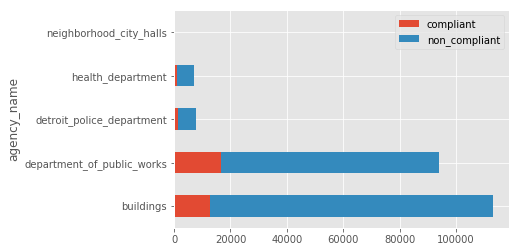

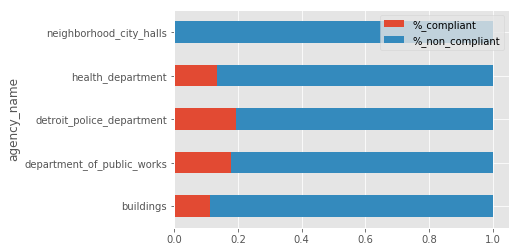

In [32]:
plot_cat_feature(model_df, 'agency_name')

This feature (which was encoded into 5 binary features) looks important because the percent compliant and non-compliant looks to depend on which agency issued the violation.

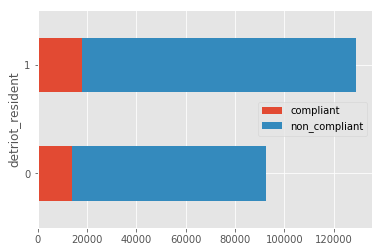

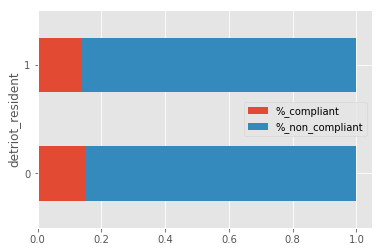

In [34]:
plot_cat_feature(model_df, 'detriot_resident')

This feature does not look important, the percent of compliant and non-compliant does not look to depend on whether the individual who received the violation resides in Detriot or not.

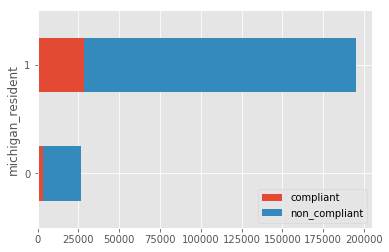

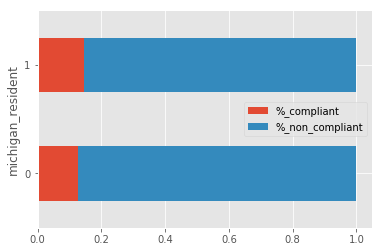

In [35]:
plot_cat_feature(model_df, 'michigan_resident')

This feature does not look important, the percent of compliant and non-compliant does not look to depend on whether the individual who received the violation resides in Michigan or not.

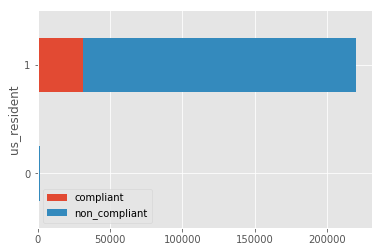

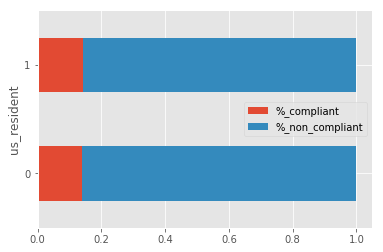

In [36]:
plot_cat_feature(model_df, 'us_resident')

This feature does not look important, the percent of compliant and non-compliant does not look to depend on whether the individual who received the violation resides in US or not.

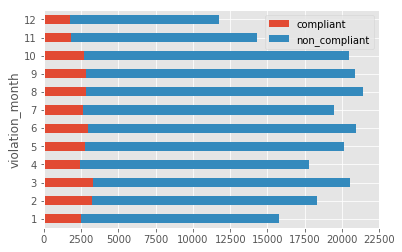

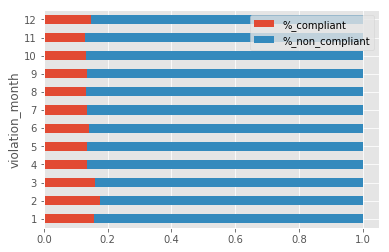

In [37]:
plot_cat_feature(model_df, 'violation_month')

This feature looks somewhat unimportant, the percent of compliant and non-compliant looks to slightly depend on what month the violation was issued on.

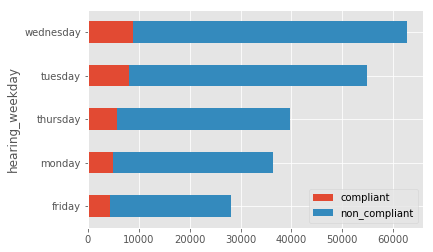

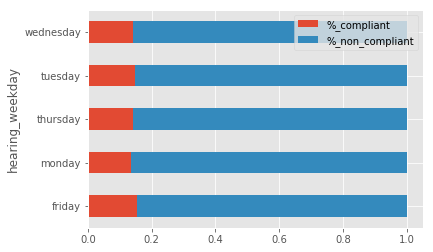

In [38]:
plot_cat_feature(model_df, 'hearing_weekday')

This feature looks important, the percent of compliant and non-compliant looks to not depend on what day the hearing date occurs on.

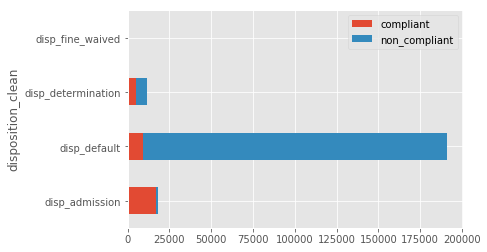

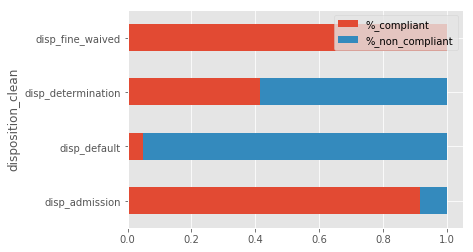

In [39]:
plot_cat_feature(model_df, 'disposition_clean')

This feature looks very important. The percent of compliant and non-compliant looks to depend very much on the ruling. 